In [1]:
!pip install vit-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 509.2 kB/s eta 0:00:00


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
import random
from torch.backends import cudnn
import matplotlib.pyplot as plt

In [3]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.data.core import Datasets

# Experiment parameters config

In [4]:
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
# set seed and set deterministic behavior, which ensure the reproducible
SEED = 2022
torch.cuda.manual_seed_all(SEED) if torch.cuda.is_available() else torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
cudnn.deterministic = True
cudnn.benchmark = False

torch.set_default_dtype(torch.float32)
torch.set_default_tensor_type(torch.FloatTensor)

# Dataset prepare

In [6]:
# model I axion dataset
# label_mean = -52.943799791658634
# label_std = 1.3254222051829239

In [7]:
class AxionData(Datasets):
    
    def __init__(self, x, y, transforms=None):
        self.x = x
        self.y = y
        self.x_transforms = transforms

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        image, label = self.x[idx], self.y[idx]
        
        # MaxMin normalization.
        image = (image - image.min()) / (image.max() - image.min())
        image = image.astype("float32")

        if self.x_transforms is not None:
            image = self.x_transforms(image)
        else:
            image = torch.from_numpy(image[None, :, :])

        # label = (np.log(label)[0] - label_mean) / label_std
        label = np.log10(label)[0]

        return image, torch.tensor(label, dtype=torch.float32)

## Transforms

In [8]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(0,360)),
])
valid_transform = transforms.Compose([
    transforms.ToTensor(),
])

## Create train and valid loader

In [9]:
image_train_dir = "../input/model2/images_mmep_train.npy"
mass_train_dir = "../input/model2/masses_mmep_train.npy"
train_len = 29896

In [10]:
image_train = np.memmap(image_train_dir, mode="r", dtype="int16", shape=(train_len, 64, 64))
mass_train = np.memmap(mass_train_dir, mode="r", dtype="float64", shape=(train_len, 1))

In [11]:
# train, validation split
# 0.9 for train 
# 0.1 for validation

num_of_images = mass_train.shape[0]
end_idx_of_train = int(num_of_images * 0.9)

all_indexes = np.random.permutation(num_of_images)
train_indexes = all_indexes[:end_idx_of_train]
valid_indexes = all_indexes[end_idx_of_train:]

In [12]:
train_set = AxionData(image_train[train_indexes], mass_train[train_indexes], train_transform)
valid_set = AxionData(image_train[valid_indexes], mass_train[valid_indexes])

In [13]:
dls = DataLoaders.from_dsets(
    train_set,
    valid_set,
    batch_size=batch_size,
    device=device,
    num_workers=4
)

## Create test loader

In [14]:
image_test_dir = "../input/model2/images_mmep_test.npy"
mass_test_dir = "../input/model2/masses_mmep_test.npy"
test_len = 5000

In [15]:
image_test = np.memmap(image_test_dir, mode="r", dtype="int16", shape=(test_len, 64, 64))
mass_test = np.memmap(mass_test_dir, mode="r", dtype="float64", shape=(test_len, 1))

test_set = AxionData(image_test, mass_test, valid_transform)

In [16]:
test_loader = DataLoader(test_set, batch_size=batch_size, device=device, num_workers=2)

# Model prepare

In [17]:
# from vit_pytorch import SimpleViT, ViT

In [18]:
# model = SimpleViT(
#     image_size = 64,
#     patch_size = 16,    # 4 * 4 = 16 patches
#     num_classes = 1,
#     dim = 1024,
#     channels=1,
#     pool='mean',
#     depth = 6,
#     heads = 8,
#     mlp_dim = 2048
# )

In [19]:
from torch import nn
from torch.nn import Conv2d

In [20]:
class ResNetReg(nn.Module):

    def __init__(self, pre_trained=True):
        """
        Args:
            pre_trained: True if want to use pretrained weight else false
        """
        super(ResNetReg, self).__init__()
        self.backbone = models.resnet34(pretrained=pre_trained)
        self.reg = nn.Sequential(
            # nn.Linear(2048, 1)
            nn.Linear(512, 1)
        )
        self.backbone.conv1 = Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.backbone.fc = self.reg

    def forward(self, x):
        return self.backbone(x)

model = ResNetReg()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

# Create learner

In [21]:
import torch

def mse_loss_wgtd(pred, true):
    loss = (pred-true).pow(2)
    return loss.mean()

def rmse_loss(p, y): 
    return torch.sqrt(mse_loss_wgtd(p.view(-1), y.view(-1)))

def mae_loss(pred, true):
    loss = (pred-true).abs()
    return loss.mean()

In [22]:
learner = Learner(
    dls,
    model,
    opt_func = ranger,
    loss_func = rmse_loss,
    metrics = [mae_loss, rmse_loss],
    model_dir = "./"
)

In [23]:
import gc
gc.collect()

90

# Find learning rate

SuggestedLRs(valley=0.007585775572806597)

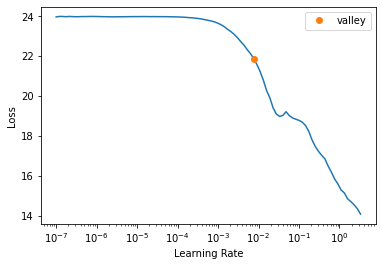

In [24]:
learner.lr_find()

# Fitting

epoch,train_loss,valid_loss,mae_loss,rmse_loss,time
0,14.941390,13.308390,13.242252,13.308390,00:24
1,8.119541,6.653792,6.626318,6.653792,00:25
2,1.239008,0.573574,0.515664,0.573574,00:24
3,0.500999,0.474398,0.567975,0.474398,00:24
4,0.449663,0.392166,0.584146,0.392166,00:24
5,0.410446,0.387161,0.608515,0.387161,00:24
6,0.401250,0.390215,0.600416,0.390215,00:25
7,0.394552,0.366338,0.601501,0.366338,00:24
8,0.387603,0.352421,0.601168,0.352421,00:24
9,0.376126,0.338336,0.603397,0.338336,00:25


Better model found at epoch 0 with rmse_loss value: 13.308389663696289.


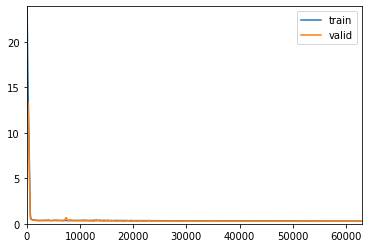

Better model found at epoch 1 with rmse_loss value: 6.653792381286621.
Better model found at epoch 2 with rmse_loss value: 0.5735744833946228.
Better model found at epoch 3 with rmse_loss value: 0.47439780831336975.
Better model found at epoch 4 with rmse_loss value: 0.39216575026512146.
Better model found at epoch 5 with rmse_loss value: 0.38716113567352295.
Better model found at epoch 7 with rmse_loss value: 0.36633753776550293.
Better model found at epoch 8 with rmse_loss value: 0.3524213135242462.
Better model found at epoch 9 with rmse_loss value: 0.33833616971969604.
Better model found at epoch 10 with rmse_loss value: 0.33028602600097656.
Better model found at epoch 36 with rmse_loss value: 0.32308173179626465.
Better model found at epoch 58 with rmse_loss value: 0.3132716417312622.
Better model found at epoch 79 with rmse_loss value: 0.30867430567741394.
Better model found at epoch 93 with rmse_loss value: 0.30787193775177.
Better model found at epoch 99 with rmse_loss value: 0

In [25]:
epochs = 300
lr = 3e-3
learner.fit_one_cycle(
    epochs,
    lr,
    cbs=[ShowGraphCallback, SaveModelCallback(monitor="rmse_loss", with_opt=True, fname="best_model")]
)

# Scatter for validation

In [26]:
valid_dl = DataLoader(valid_set, batch_size=batch_size, device=device, num_workers=2)

MAE: TensorBase(0.2146)


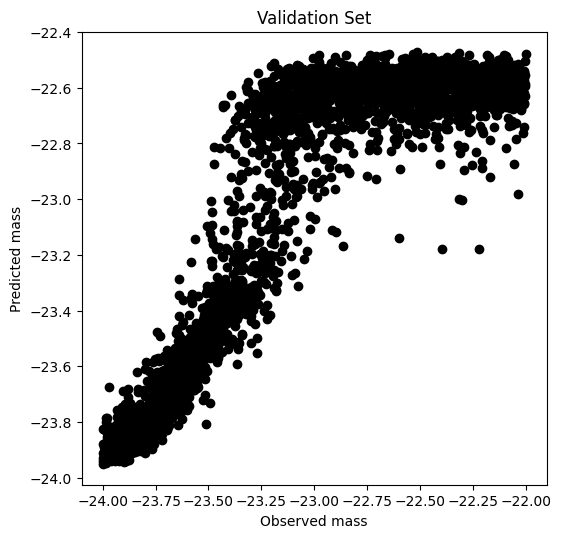

In [27]:
y_pred, y_true = learner.get_preds(dl=valid_dl)
valid_mae = mae(y_pred, y_true)
plt.figure(figsize=(6, 6), dpi=100)
plt.scatter(y_true, y_pred,  color='black')
#line = np.linspace(-2, 0, 100)
#plt.plot(line, line)
plt.title("Validation Set")
plt.xlabel('Observed mass')
plt.ylabel('Predicted mass')
print("MAE:", valid_mae)

# Load best model

In [28]:
learner.load("best_model", device=device)
learner.model = learner.model.to(device)

MAE: TensorBase(0.2146)


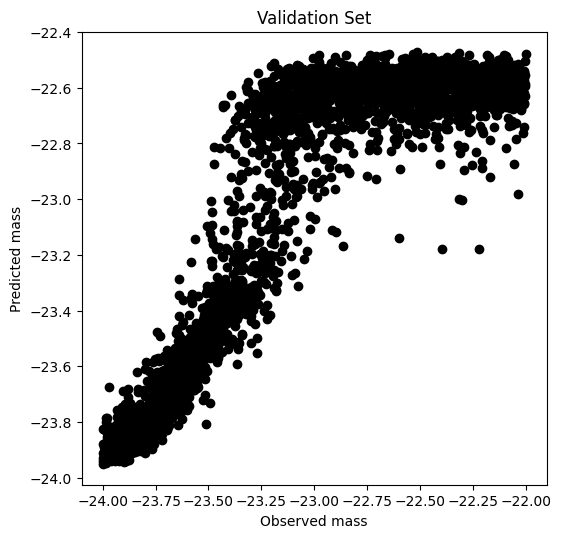

In [29]:
y_pred, y_true = learner.get_preds(dl=valid_dl)
valid_mae = mae(y_pred, y_true)
plt.figure(figsize=(6, 6), dpi=100)
plt.scatter(y_true, y_pred,  color='black')
#line = np.linspace(-2, 0, 100)
#plt.plot(line, line)
plt.title("Validation Set")
plt.xlabel('Observed mass')
plt.ylabel('Predicted mass')
print("MAE:", valid_mae)

# Scatter for test

In [30]:
y_pred, y_true = learner.get_preds(dl=test_loader)

In [31]:
np.savez("./label_pred_true.npz", mass_pred=y_pred, mass_true=y_true)

MAE: TensorBase(0.2162)


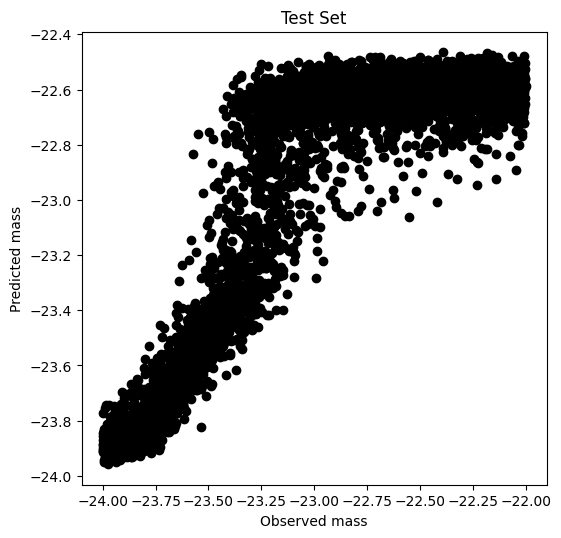

In [32]:
test_mae = mae(y_pred, y_true)
plt.figure(figsize=(6, 6), dpi=100)
plt.scatter(y_true, y_pred,  color='black')
#line = np.linspace(-2, 0, 100)
#plt.plot(line, line)
plt.title("Test Set")
plt.xlabel('Observed mass')
plt.ylabel('Predicted mass')
print("MAE:", test_mae)

# Cancel standartization

In [33]:
# y_pred = np.exp((y_pred + label_mean) * label_std)
# y_true = np.exp((y_true + label_mean) * label_std)

In [34]:
# test_mae = mae(y_pred, y_true)
# plt.figure(figsize=(6, 6), dpi=100)
# plt.scatter(y_true, y_pred,  color='black')
# #line = np.linspace(-2, 0, 100)
# #plt.plot(line, line)
# plt.title("Test Set (cancel standartization)")
# plt.xlabel('Observed mass')
# plt.ylabel('Predicted mass')
# print(test_mae)